In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

plt.style.use(['science','no-latex'])
plt.rcParams["figure.figsize"] = (6.5,6.5)
plt.rcParams['font.size'] =  15


In [2]:
dout="model_compare"

In [3]:
# modules = (fc.eightb.preselection, fc.eightb.preselection_golden, fc.eightb.preselection_onnx)
# labels = ['t8btag_minmass','golden_gnn','particle_net']

modules = (fc.eightb.preselection,  fc.eightb.preselection_onnx)
labels = ['t8btag_minmass','particle_net']

In [4]:
signals = ObjIter([ Tree( module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450 ) for module in modules])
bkgs = ObjIter([ Tree( module.Bkg_MC_List ) for module in modules])
treeiter = signals + bkgs

In [5]:
signals.sample

['MX_1000_MY_450', 'MX_1000_MY_450']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


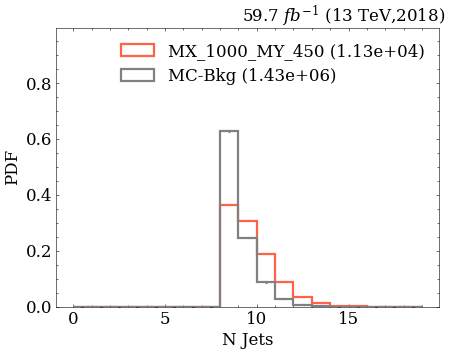

In [6]:
study.quick(
  [signals[0], bkgs[0]],
  varlist=['n_jet',],
  binlist=[np.arange(20)],
  legend=True, density=True,

  saveas=f"{dout}/n_jets"
)

In [7]:
def count_signal_jets(tree):
  genHflag = ak.unzip(tree[[f'{quark}_genHflag' for quark in eightb.quarklist]])
  genHflag = ak.concatenate([flag[:,None] for flag in genHflag], axis=-1)
  nsig = ak.sum(genHflag>-1,axis=-1)
  tree.extend(nfound_select=nsig)
signals.apply(count_signal_jets)

[None, None]

In [8]:
class varfrac(ObjTransform):
  def __call__(self, tree):
    return tree[self.num]/tree[self.den]

In [ ]:
varinfo.nfound_presel = dict(xlabel='N Signal B-Jets in Preselection', bins=None)
varinfo.nfound_selected = dict(xlabel='N Signal B-Jets in Selected', bins=None)


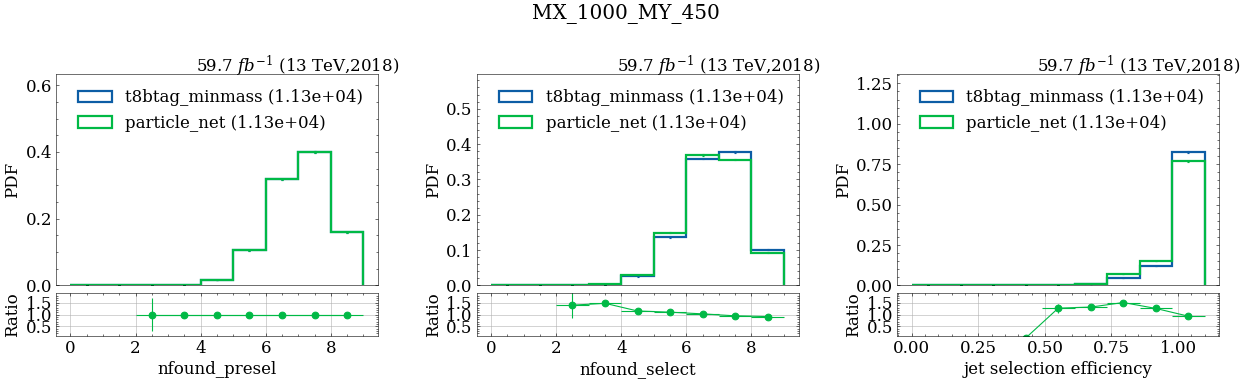

In [9]:
study.quick(
  signals,h_color=None,label=labels,legend=True,
  varlist=['nfound_presel','nfound_select',varfrac(num='nfound_select',den='nfound_presel', name='jet selection efficiency')],
  binlist=[np.arange(10), np.arange(10), np.linspace(0,1.1,10)],
  density=True, title=signals[0].sample,
  dim=(-1, 3),
  ratio=True, r_inv=True,
  saveas=f"{dout}/n_signal_jets"

)

In [ ]:
varinfo.nfound_presel_h = dict(xlabel='N Higgs in Preselection', bins=None)
varinfo.nfound_paired_h = dict(xlabel='N Higgs Paired in Selected', bins=None)


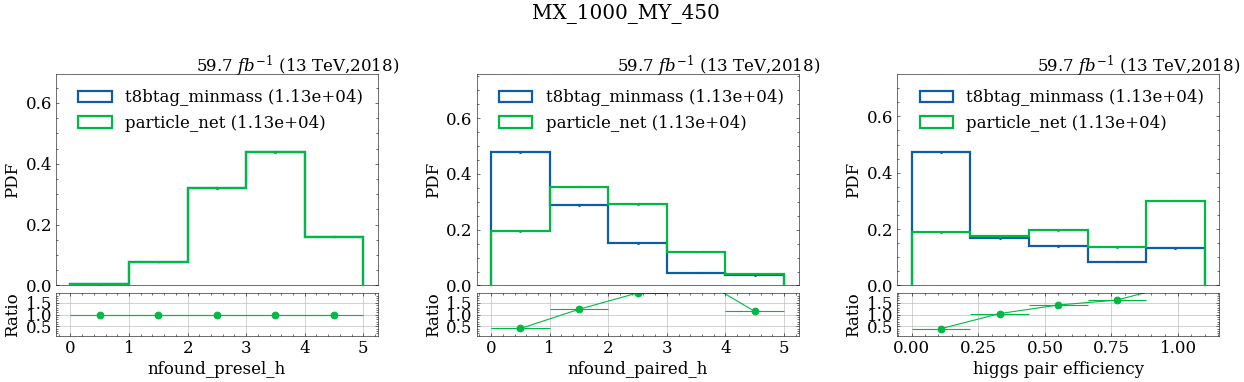

In [10]:
study.quick(
  signals,h_color=None,label=labels,legend=True,
  varlist=['nfound_presel_h','nfound_paired_h',varfrac(num='nfound_paired_h',den='nfound_presel_h',name='higgs pair efficiency')],
  binlist=[np.arange(6), np.arange(6), np.linspace(0,1.1,6)],
  density=True, title=signals[0].sample,
  dim=(-1,3),
  ratio=True, r_inv=True,
  saveas=f"{dout}/n_higgs_paired"
)

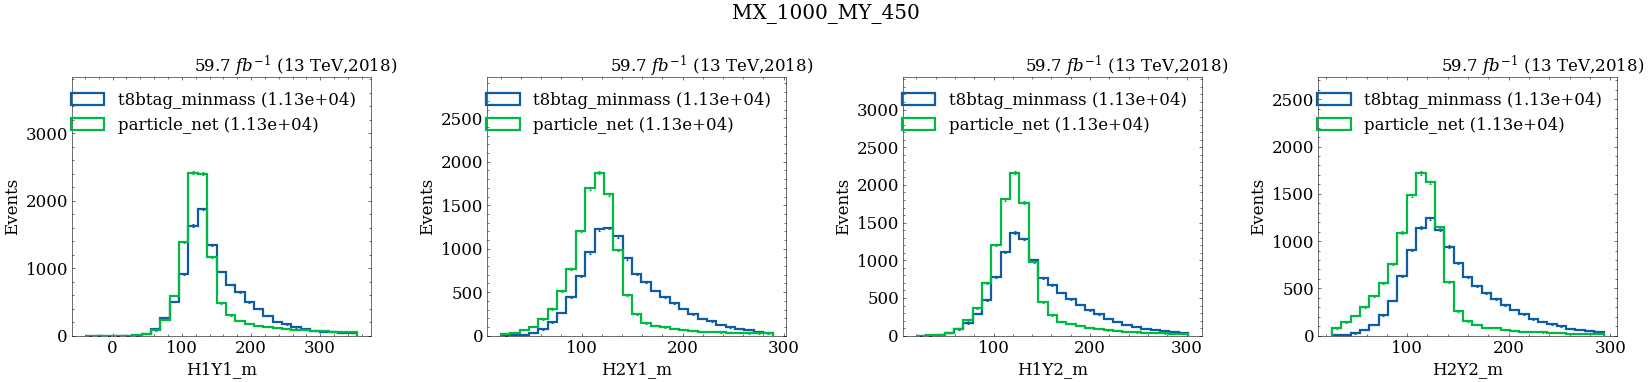

In [11]:
study.quick(
  signals,h_color=None, label=labels, legend=True,
  varlist=['H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
  dim=(-1,4), title=signals[0].sample,
  saveas=f"{dout}/higgs_mass_shape"
)

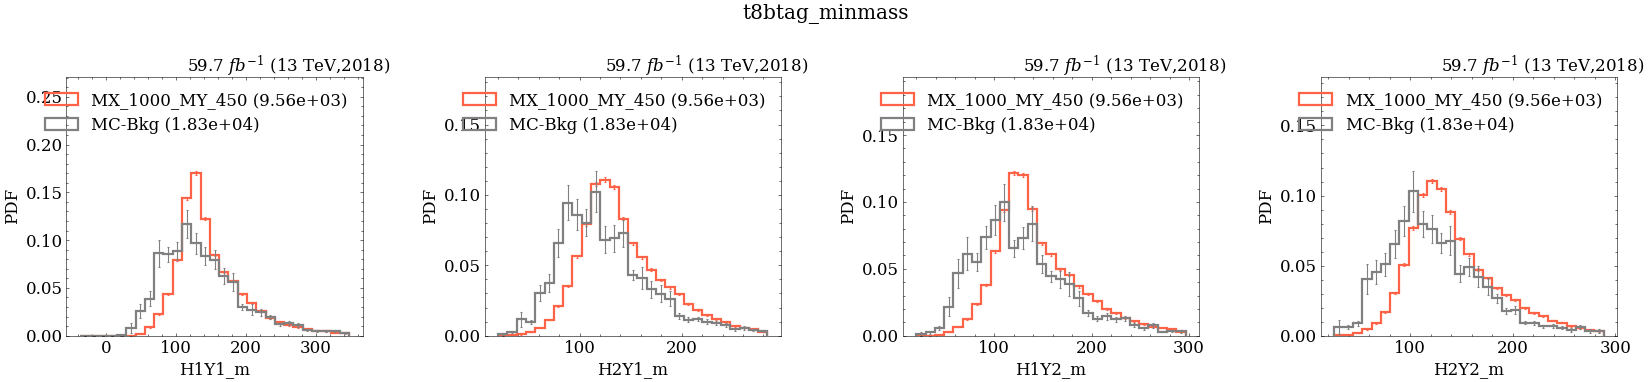

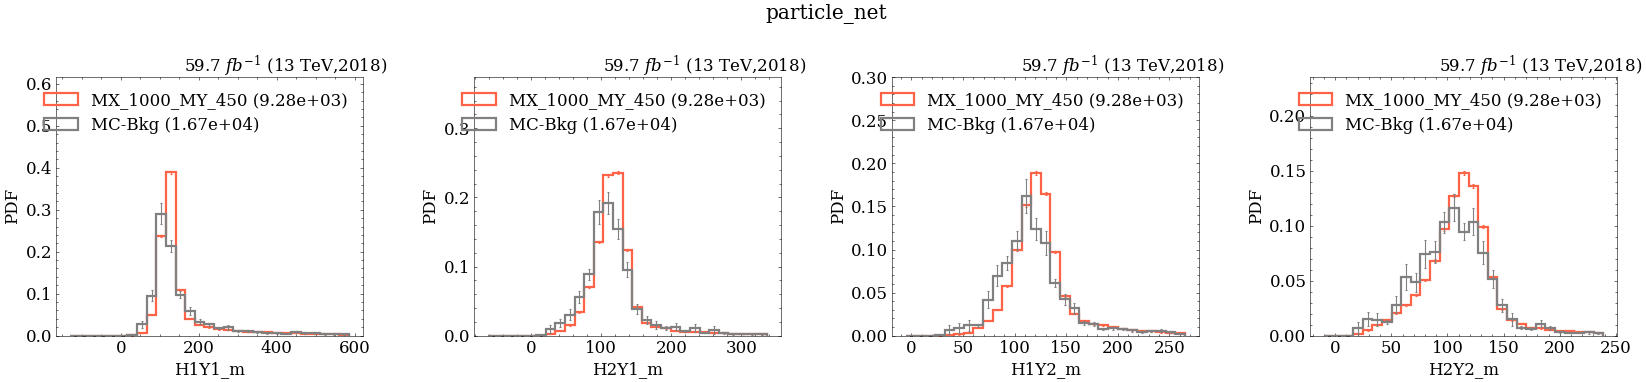

In [32]:
for i,method in enumerate(labels):
  study.quick(
    signals[[i]]+bkgs[[i]],
    masks=lambda t:t.n_medium_btag>4,
    varlist=['H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    dim=(-1,4),
    legend=True, density=True,
    title=method,

    # ratio=True, r_label_stat='y_std', r_legend=True, r_ylim=None,
    # difference=True, d_label_stat='y_mean_std', d_legend=True, d_ylim=None, d_size="50%",

    saveas=f"{dout}/{method}_bkg_higgs_mass_shape"
  )

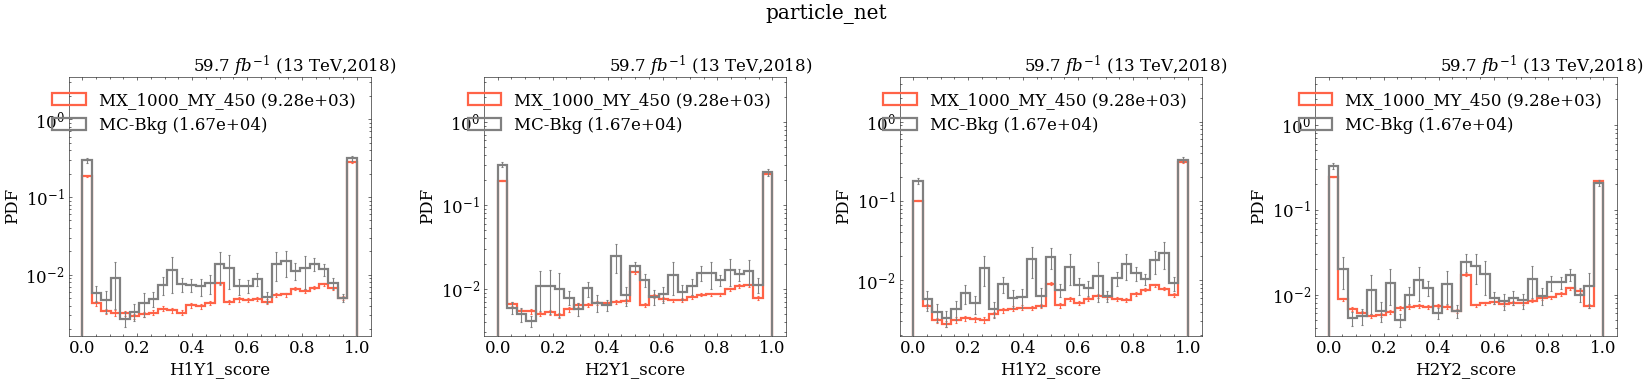

In [31]:
study.quick(
  signals[[1]]+bkgs[[1]],
  varlist=['H1Y1_score','H2Y1_score','H1Y2_score','H2Y2_score'],
  dim=(-1,4),
  legend=True, density=True, log=True,
  title=method,

  # ratio=True, r_label_stat='y_std', r_legend=True, r_ylim=None,
  # difference=True, d_label_stat='y_mean_std', d_legend=True, d_ylim=None, d_size="50%",

  saveas=f"{dout}/particle_net_bkg_higgs_score_shape"
)

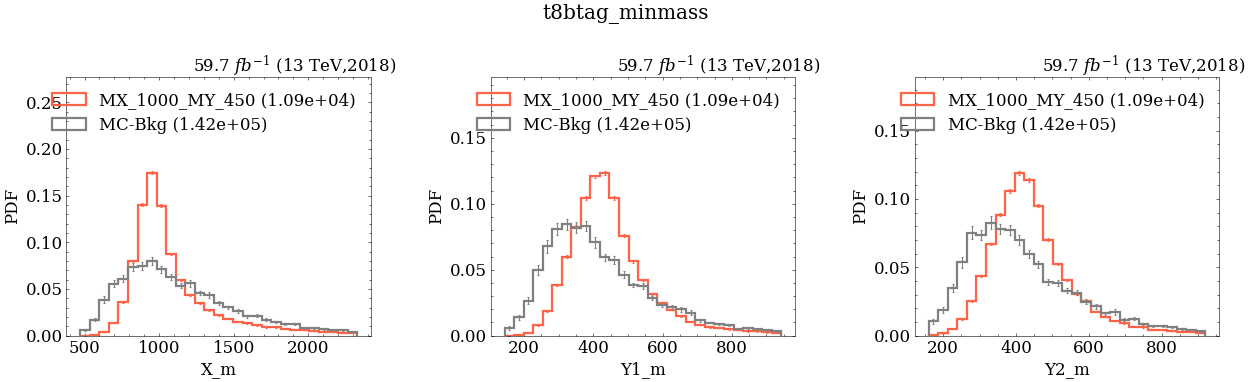

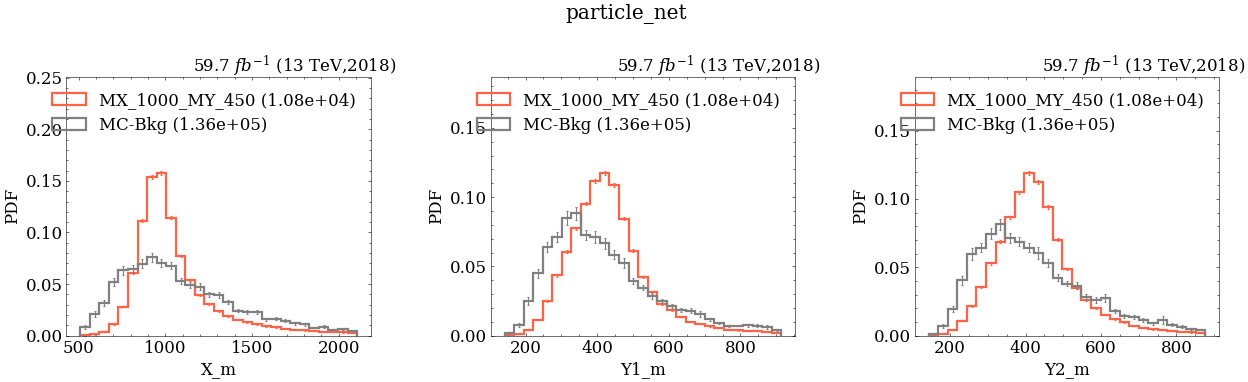

In [34]:
for i,method in enumerate(labels):
  study.quick(
    signals[[i]]+bkgs[[i]],
    masks=lambda t:t.n_medium_btag>3,
    varlist=['X_m','Y1_m','Y2_m'],
    dim=(-1,3),
    legend=True, density=True,
    title=method,

    
    # ratio=True, r_label_stat='y_std', r_legend=True, r_ylim=None,
    # difference=True, d_label_stat='y_mean_std', d_legend=True, d_ylim=None, d_size="50%",

    # saveas=f"{dout}/{method}_bkg_resonance_mass_shape"
  )

In [15]:
dijets = get_collection(signals[-1], 'dijet', False)[0]
dijets = dijets[ak.argsort(-dijets.score)]
n_dijets = ak.count(dijets)

In [16]:
idxs = []
table = []
for i in range(n_dijets):
  if len(idxs) == 8: break

  row = []

  row = row + [dijets.j1Idx[i],dijets.j2Idx[i], f"{dijets.score[i]:.2e}"]

  if dijets.j1Idx[i] in idxs or dijets.j2Idx[i] in idxs:
    row = row + ["0"] 
  else:
    idxs = idxs + [dijets.j1Idx[i], dijets.j2Idx[i]]
    row = row + ["1"]
  print(' '.join([str(r) for r in row]))

0 8 1.00e+00 1
1 2 1.00e+00 1
1 6 1.00e+00 0
7 8 1.00e+00 0
0 5 1.00e+00 0
2 4 1.00e+00 0
1 4 1.00e+00 0
4 8 9.88e-01 0
6 7 9.78e-01 1
0 3 8.91e-01 0
5 6 8.56e-01 0
3 7 5.63e-01 0
2 6 5.00e-01 0
4 6 3.32e-01 0
2 5 1.31e-01 0
0 4 2.15e-04 0
3 4 9.35e-06 1


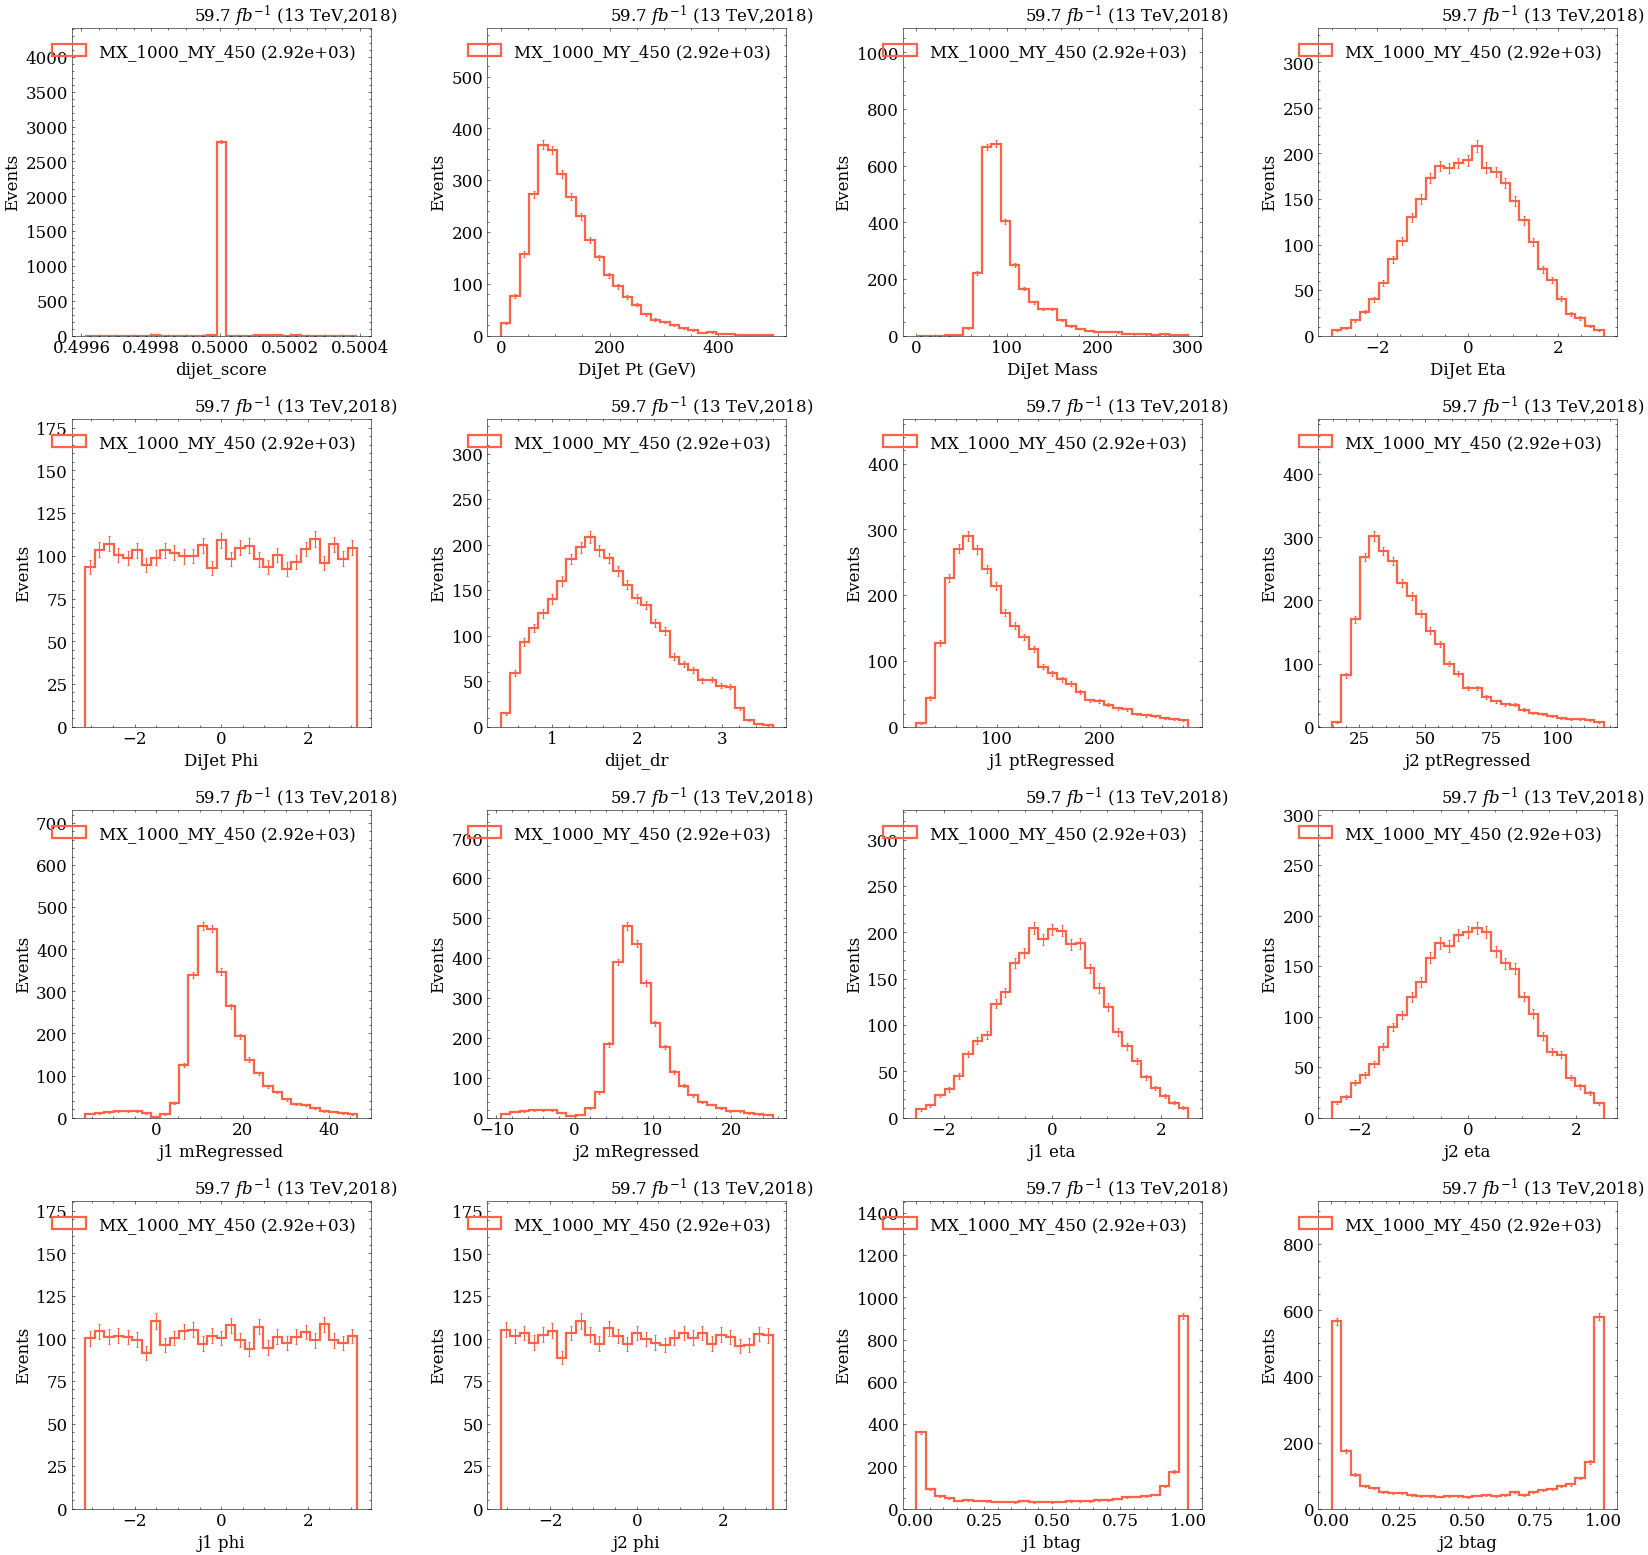

In [17]:
class get_jet_var(ObjTransform):
  def __call__(self, tree):
    idx = tree[f'dijet_j{self.i}Idx']
    return tree[f'jet_{self.var}'][idx]

study.quick(
  signals[[-1]],
  masks=lambda t: (np.abs(t.dijet_score - 0.5) < 0.001), legend=True,
  varlist=['dijet_score','dijet_pt','dijet_m','dijet_eta','dijet_phi','dijet_dr'] + [
    get_jet_var(var=var,i=i+1,name=f'j{i+1} {var}')
    for var in ('ptRegressed','mRegressed','eta','phi','btag')
    for i in range(2)
  ],
  dim=(-1, 4),

  saveas=f'{dout}/weird_dijet_score_peak'
)